# The drug problem in Europe

## Overdose deaths

Overdose deaths is a serious problem - perhaps one of the biggest problems regarding drug abuse. In this section we will try to figure out the patterns and analyze overdose deaths per country.

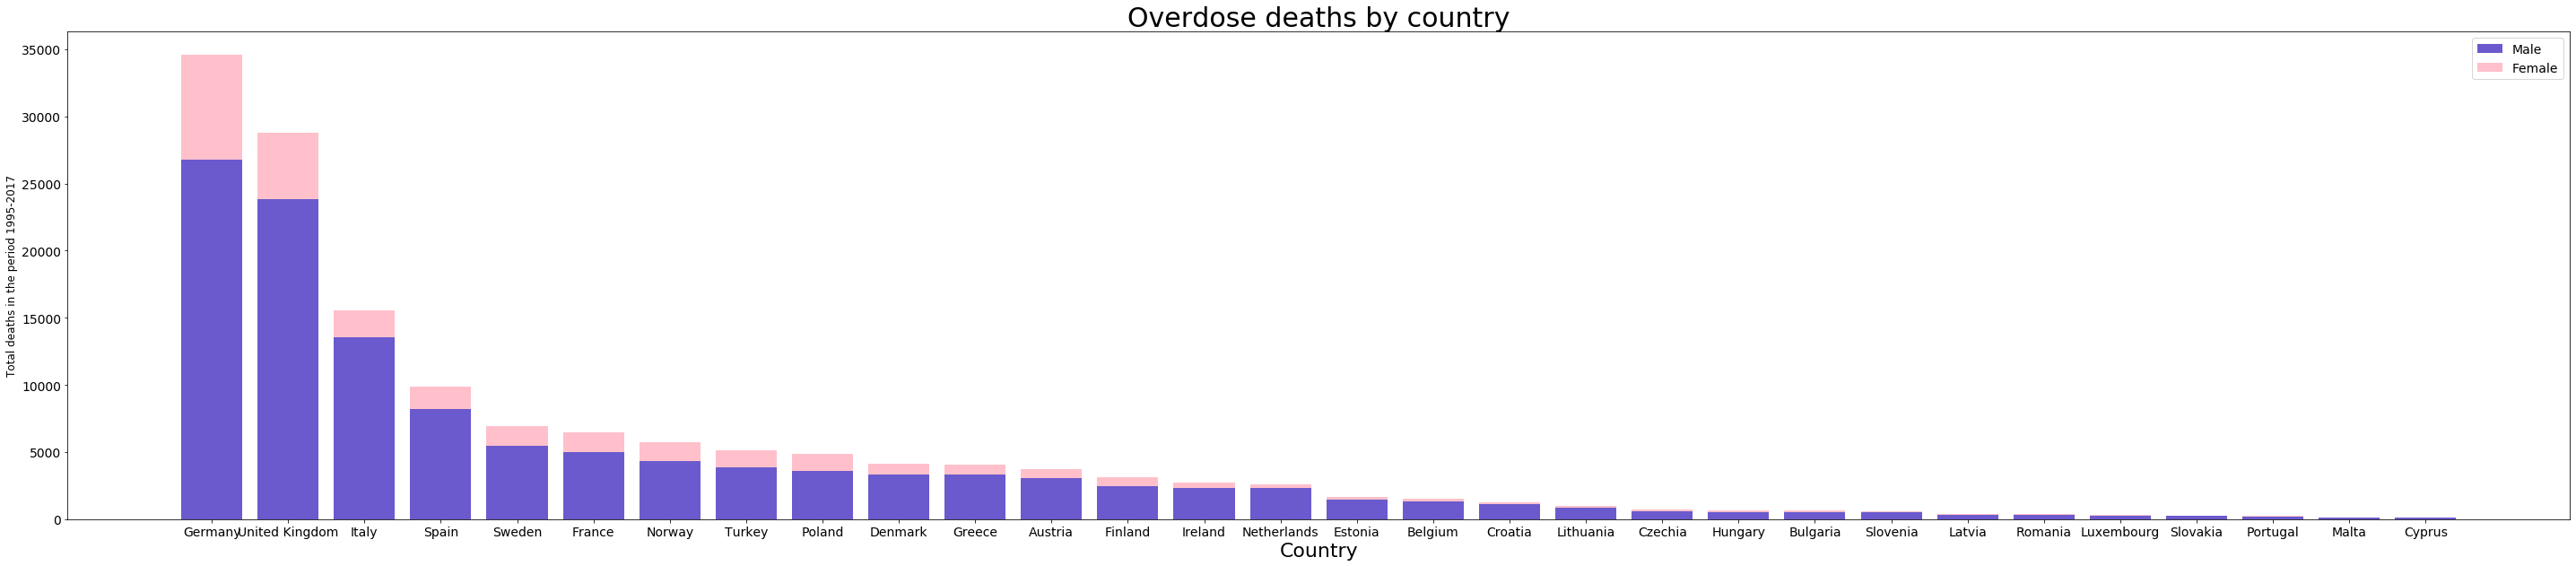

In [3]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

%matplotlib inline


plt.rcParams.update({'font.size': 14})
m = pandas.read_excel("./tables/drugDeaths/maleDeaths.xlsx")
m.fillna(0)
f = pandas.read_excel("./tables/drugDeaths/femaleDeaths.xlsx") 
f.fillna(0)
plt.figure(figsize=(50,10))

dataM = {}
dataF = {}
def replaceNan(data, indxs, val):
    for (i,v) in enumerate(indxs):
        if v == True:
            data[i] = val
for i,row in m.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].strip().replace("*", "").strip()
        dataM[country] = [row[col] for col in m.columns[:-1][1:]]
        nan_indx = np.isnan(dataM[country])
        replaceNan(dataM[country], nan_indx,0)
    
for i,row in f.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].strip().replace("*", "").strip()
        dataF[country] = [row[col] for col in f.columns[:-1][1:]]
        nan_indx = np.isnan(dataF[country])
        replaceNan(dataF[country], nan_indx,0)
        
sortedMaleKeys = sorted(dataM, key = lambda k: sum(dataM[k]), reverse=True)
maleY=[sum(dataM[k])  for k in sortedMaleKeys]
femaleY=[sum(dataF[k])  for k in sorted(dataF, key = lambda k: sum(dataF[k]), reverse = True)]




plt.bar(sortedMaleKeys, maleY, color="slateblue", label="Male")
plt.bar(sortedMaleKeys, femaleY, bottom = maleY ,color="pink", label="Female")

plt.title("Overdose deaths by country",fontsize=30)
plt.xlabel("Country",fontsize=22)
plt.ylabel("Total deaths in the period 1995-2017",fontsize=12)


data =[sum(dataM[k]) + sum(dataF[k])  for k in sortedMaleKeys]

zscores = dict(zip(sortedMaleKeys,stats.zscore(data)))

stdDeaths = np.std(data)
meanDeaths = np.mean(data)
plt.legend()
plt.show()

<Figure size 1080x720 with 0 Axes>

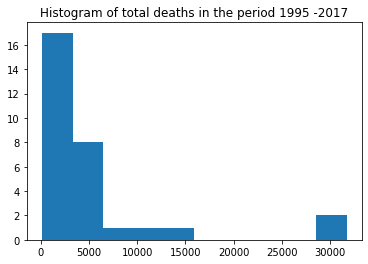

<Figure size 1080x720 with 0 Axes>

In [4]:
plt.hist(data)
plt.title("Histogram of total deaths in the period 1995 -2017")
plt.figure(figsize=(15, 10))

If we look at the histogram, we can see that the data about deaths per country is normally distributed(positively skewed) - with three outliers(we can see that they are Germany, the UK and Spain. So we can use the Z-score to calculate the p-value. I will use this information to plot a map. Colors will be going from green to red(red indicating high Z-score, green indicating low z-score).

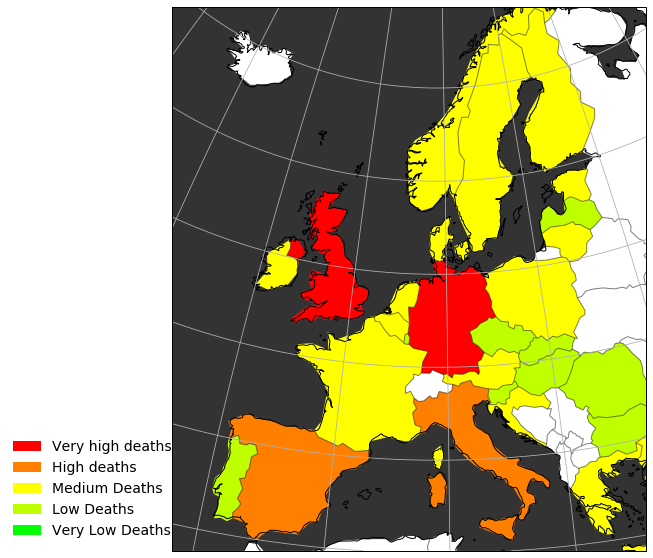

In [5]:
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
def getColor(zVal):
    bot10 = stats.norm.ppf(0.05)
    top10 = stats.norm.ppf(1-0.05)
    
    bot30 = stats.norm.ppf(0.3)
    top30 = stats.norm.ppf(1-0.3)

    if zVal > bot10 and zVal < top10:
        if zVal > bot30 and zVal < top30:
            return (1,1,0) ##yellow
        if zVal> bot30:
            return (1,0.5,0) ##orange
        return (0.75,1,0) ##lime
    
    
    
    if zVal> bot10:
        return (1,0,0) ##red
    return (0,1,0) ##green
    
    
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.EuroPP())

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    if country.attributes["NAME"] in sortedMaleKeys:
        ax.add_geometries([country.geometry], crs=ccrs.PlateCarree(), facecolor=getColor(zscores[country.attributes["NAME"]]))

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.OCEAN,facecolor=(0.2,0.2,0.2))
ax.gridlines()
values = ["Very high deaths", "High deaths", "Medium Deaths", "Low Deaths", "Very Low Deaths"]
rects = []

colors = [(1,0,0), (1,0.5,0), (1,1,0), (0.75,1,0), (0,1,0)]
for i in range(len(values)):
    rects.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i]))
    
ax.legend(rects, values,loc='lower right', bbox_to_anchor=(0.025, -0.0), fancybox=True, frameon=False, fontsize=14)  

leg = ax.get_legend()




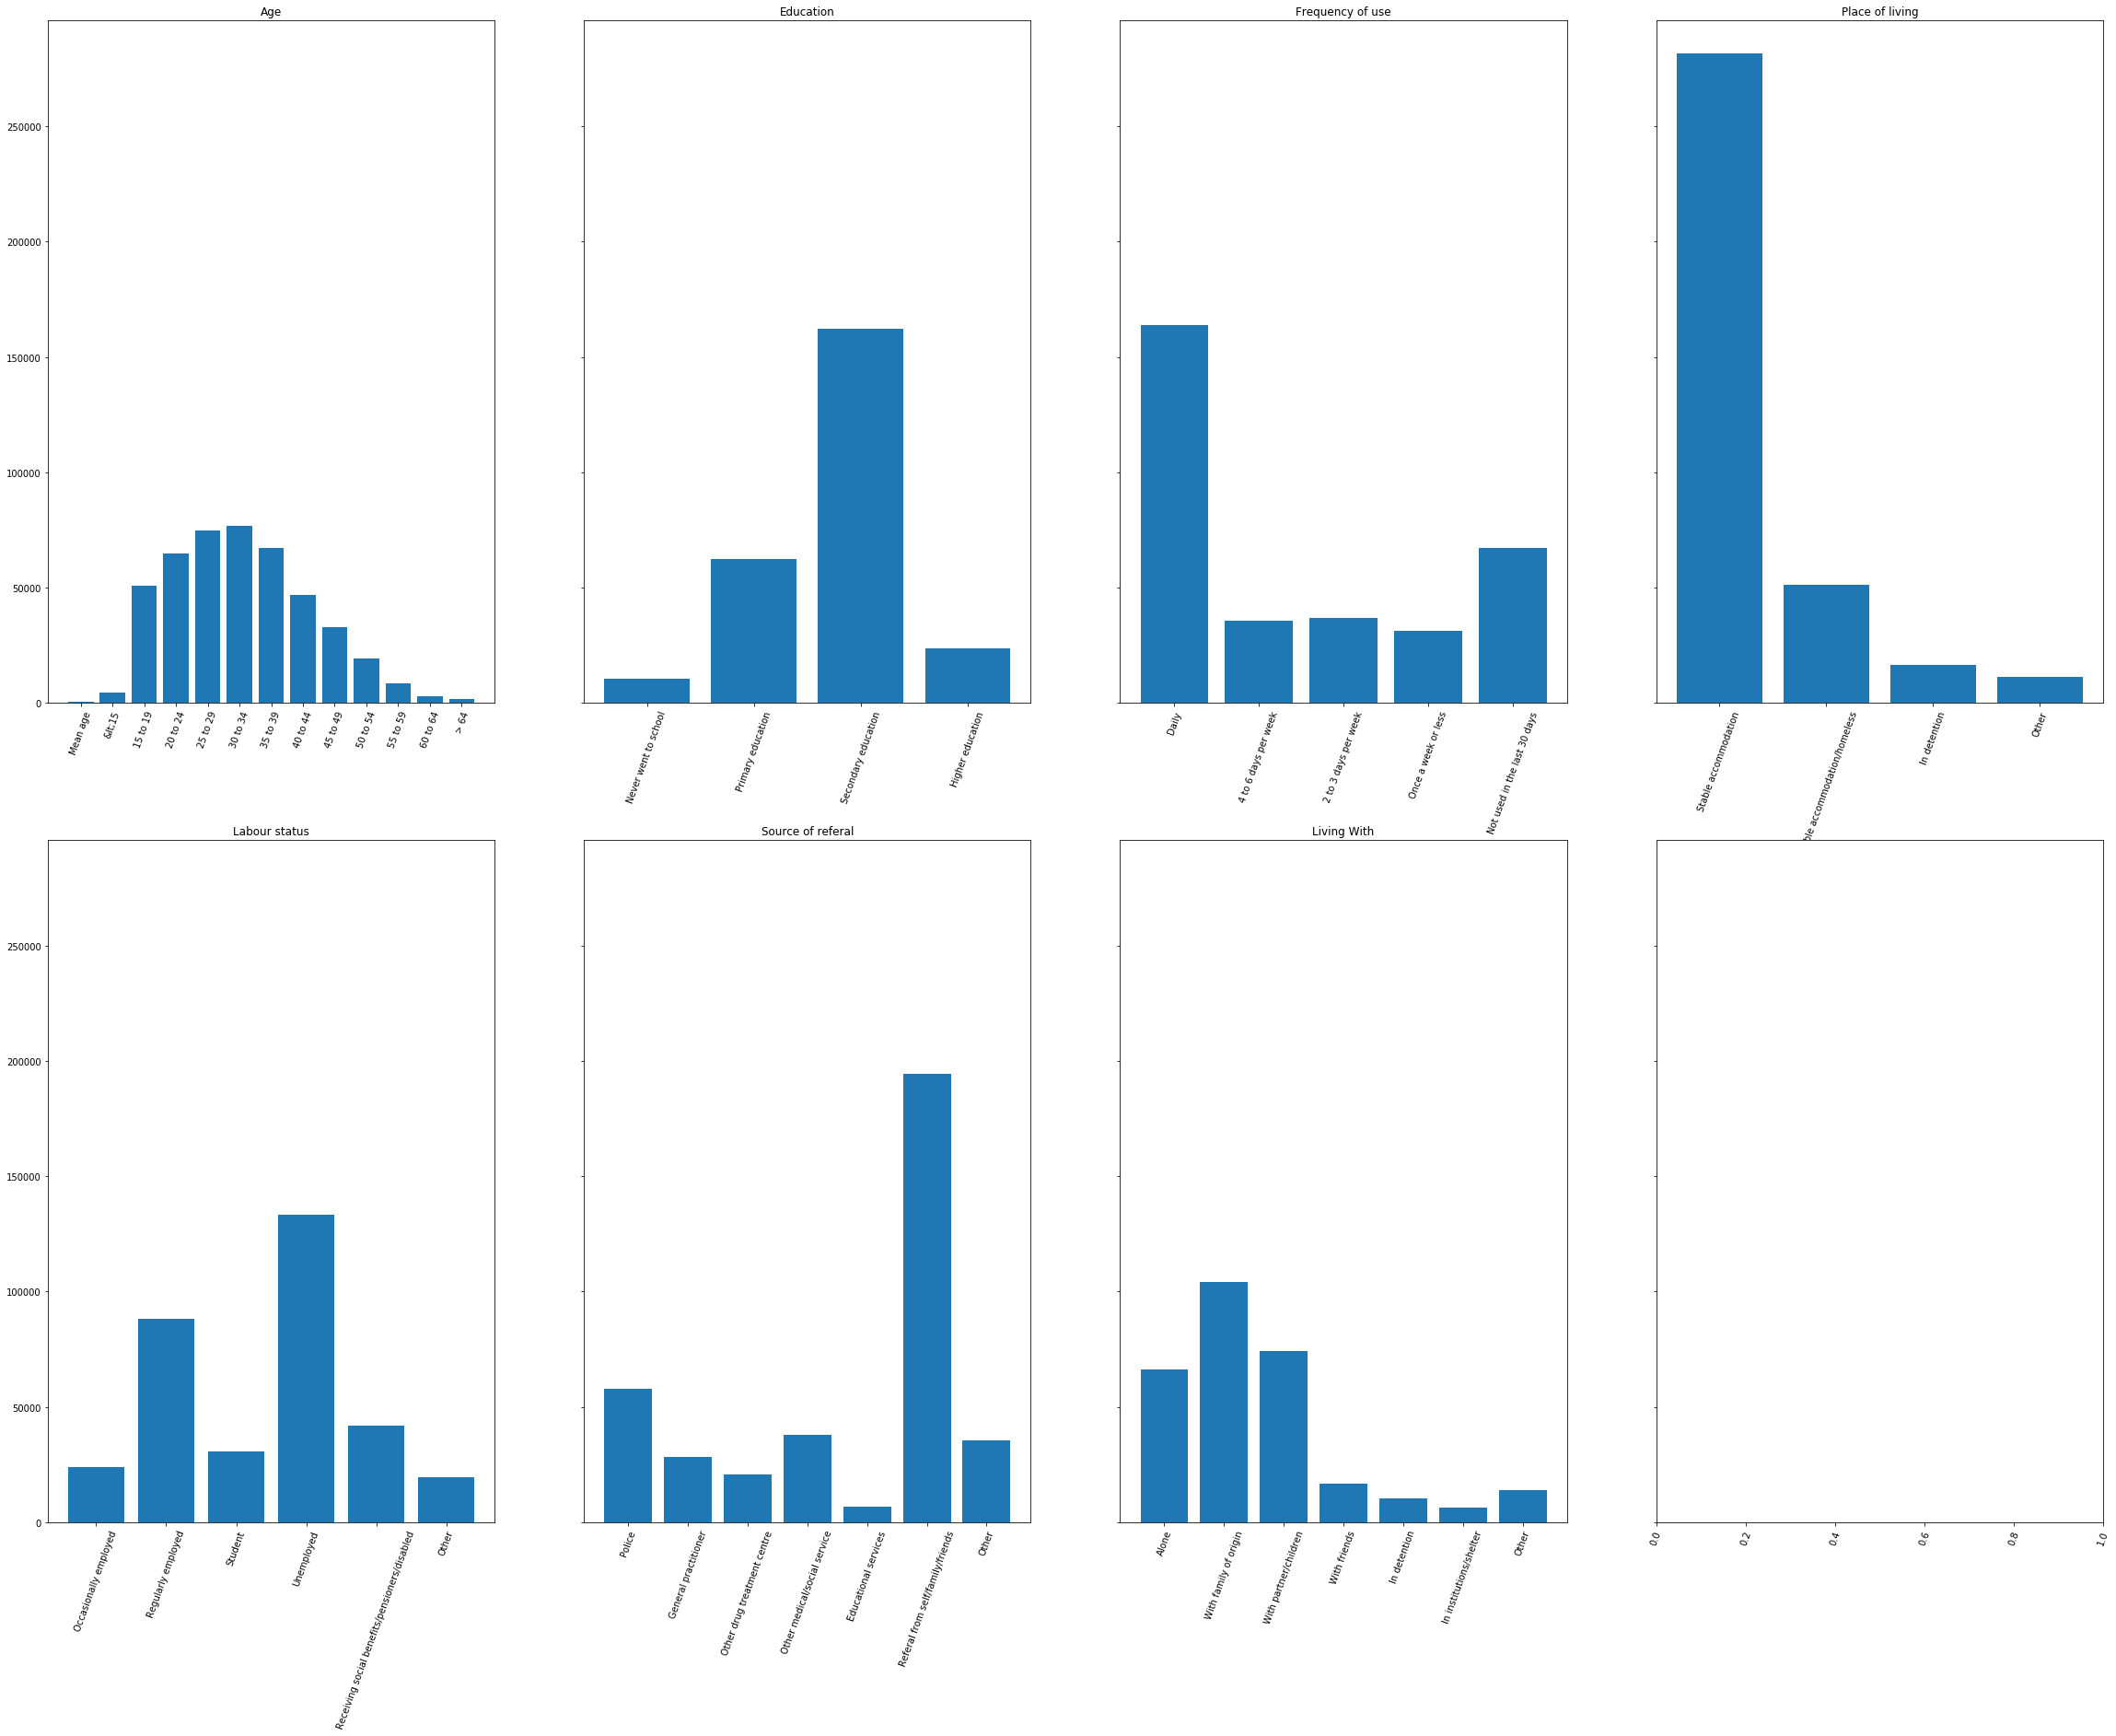

In [6]:
import math
tables = [{"file": "./tables/treatmentDemand/currentTrends/ageOfTreatment.xlsx", "title": "Age"}, 
          {"file":  "./tables/treatmentDemand/currentTrends/education.xlsx", "title": "Education"},
          {"file": "./tables/treatmentDemand/currentTrends/frequencyOfUse.xlsx", "title": "Frequency of use"},
          {"file": "./tables/treatmentDemand/currentTrends/livingWhere.xlsx", "title": "Place of living"},
          {"file": "./tables/treatmentDemand/currentTrends/labourStatus.xlsx", "title": "Labour status"},
          {"file": "./tables/treatmentDemand/currentTrends/sourceOfReferal.xlsx", "title": "Source of referal"},
          {"file": "./tables/treatmentDemand/currentTrends/livingWithWhom.xlsx", "title": "Living With"}]
fig, axs = plt.subplots(2, 4, figsize=(40, 30), sharey=True)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

for (num, tab) in enumerate(tables):
    currentTable = dict()
    
    file = pandas.read_excel(tab["file"])
    for i,row in file.iterrows():
        if type(row["Country"]) is str:
            for col in file.columns[:-3][2:]:
                if not col in currentTable and not np.isnan(row[col]):
                    currentTable[col] = row[col]
                elif not np.isnan(row[col]):
                    currentTable[col] += row[col]
    axs[math.floor(num/4)][num%4].bar(currentTable.keys(), currentTable.values())
    axs[math.floor(num/4)][num%4].set_title(tab["title"])
    



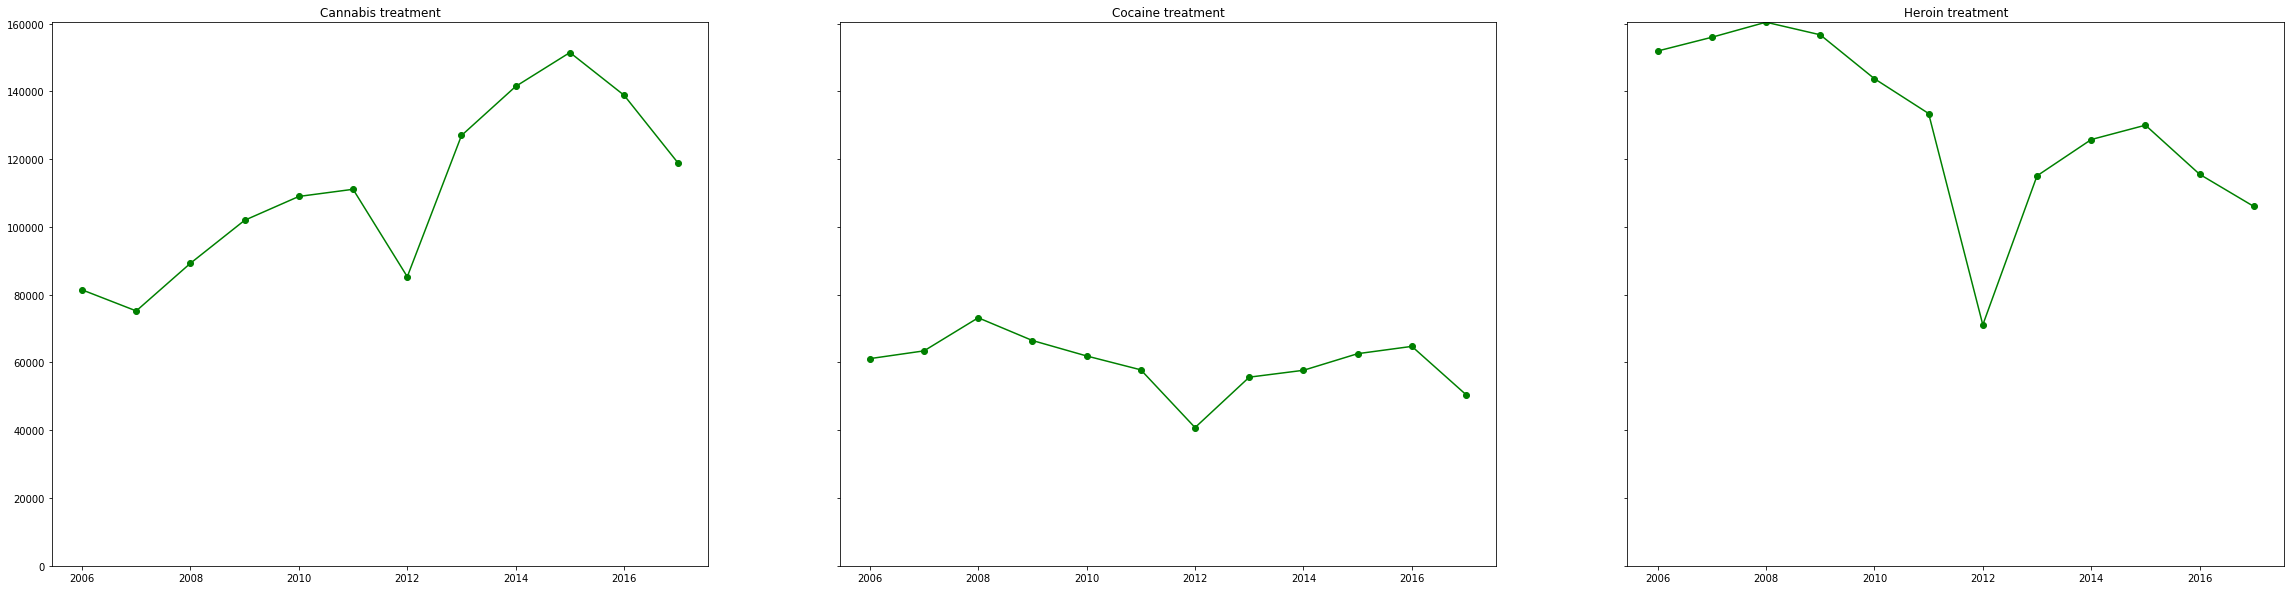

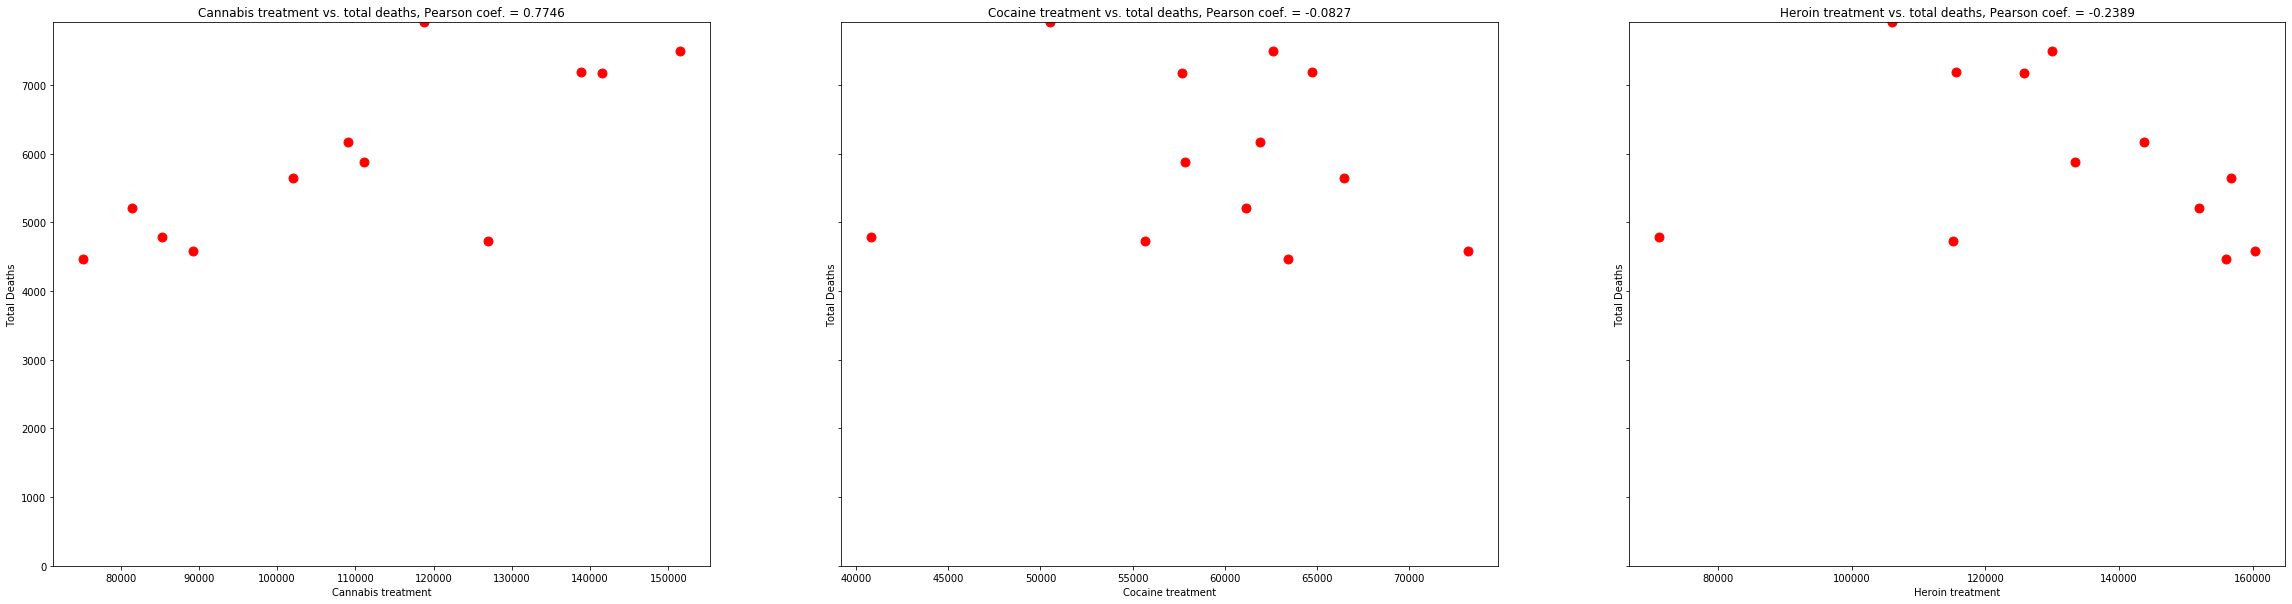

In [9]:
tables = [{"title":"Cannabis treatment", "path": "./tables/treatmentDemand/throughTheYears/cannabisTreatment.xlsx"}, 
         {"title":"Cocaine treatment", "path": "./tables/treatmentDemand/throughTheYears/cocaineTreatment.xlsx"},
         {"title":"Heroin treatment", "path": "./tables/treatmentDemand/throughTheYears/heroinTreatment.xlsx"}]
fig, axs = plt.subplots(1, 3, figsize=(40, 10), sharey=True)
fig1, axs1 = plt.subplots(1, 3, figsize=(40, 10), sharey=True)

deaths_by_year = []
for i in range(22):
    vy =0
    for country in dataM.keys():
        vy+= dataM[country][i] + dataF[country][i]
    deaths_by_year.append(vy)

cor_tables = []
for (num, tab) in enumerate(tables):
    currentTable = dict()
    file = pandas.read_excel(tab["path"])
    for i,row in file.iterrows():
        if type(row["Country"]) is str:
            for col in file.columns[1:][:-1]:
                if not col in currentTable and not np.isnan(row[col]):
                    currentTable[int(col)] = row[int(col)]
                elif not np.isnan(row[int(col)]):
                    currentTable[int(col)] += row[int(col)]
                    
    axs[num].set_ylim(0, max(currentTable.values()))
    axs[num].scatter(currentTable.keys(), currentTable.values(), color="green")
    axs[num].plot([float(k) for k in currentTable.keys()], [float(v) for v in currentTable.values()], color="green")
    
    dths = deaths_by_year[-len(currentTable.keys()):]
    
    axs1[num].set_ylim(0, max(dths))
    axs1[num].scatter(currentTable.values(),dths , color="red", s=80)
    
    axs[num].set_title(tab["title"])
    coef = np.corrcoef(x=np.array([float(v) for v in currentTable.values()]), y=np.array(dths))
    axs1[num].set_title(tab["title"] +" vs. total deaths, Pearson coef. = " + str(round(coef[0][1], 4)) )
    axs1[num].set_xlabel(tab["title"])
    axs1[num].set_ylabel("Total Deaths")
    

    

In [11]:
ost_table = dict()
file = pandas.read_excel("./tables/socialResponses/opioidSubstitutionTreatment.xlsx")

for row in file.iterrows():
    if type(row["Country"]) is str:
        country = country = row["Country"].strip().replace("*", "").strip()
        for col in file.columns[:-1][2:]
        
    